# Определение стоимости автомобилей

## Подготовка данных

### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV

### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [3]:
data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

После первого взгляда на загруженные данные предлагаю все наименования полей привести к стандарту PEP8, а именно указать наименования со строчной буквы, разделить при помощи символа "_", а так же изменить DateCreated, DateCrawled и LastSeen к формату datatime (сделали это через parse при загрузке данных)

In [5]:
data.columns = data.columns.str.lower()

In [6]:
data.rename(columns = {'registrationyear': "registration_year",
                       'registrationmonth': "registration_month",
                      'datecreated': "date_created",
                      "numberofpictures": 'number_of_pictures',
                      "postalcode": 'postal_code',
                      "lastseen": 'last_seen',
                      "fueltype": 'fuel_type',
                      "datecrawled": 'date_crawled',
                      "vehicletype": 'vehicle_type'}, inplace = True)

In [7]:
data.head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Теперь данные приведены к стандарту PEP8. \
После загрузки видны пропуски в нескольких столбцах, в остальном всё впорядке, проведем предообработку данных.

### Предобработка данных

In [8]:
display(f'Дубликаты data: {data.duplicated().sum()}')

'Дубликаты data: 4'

In [9]:
data[data.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


обнаружили 4 дубликата, предлагаю их удалить

In [10]:
data = data.drop_duplicates()

In [11]:
display(f'Дубликаты data: {data.duplicated().sum()}')

'Дубликаты data: 0'

Предлагаю избавиться от столбцов, которые нам не нужны. При выборе нужных столбцов ориентировался на логику.

In [12]:
data = data.drop(['number_of_pictures', 
                  'postal_code', 'date_created',
                  'last_seen', 'registration_month',
                  'date_crawled'], axis=1)

In [13]:
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN


### Пропуски

In [14]:
#repaired заменим на unknown
data.repaired.fillna('unknown', inplace=True)

In [15]:
data.repaired.unique()

array(['unknown', 'yes', 'no'], dtype=object)

In [16]:
#data.fuel заменим на other
data['fuel_type'] = data['fuel_type'].fillna('other')

In [17]:
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown


In [18]:
data.fuel_type.unique()

array(['petrol', 'gasoline', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [19]:
# vehicle_type заменим на other
data['vehicle_type'] = data['vehicle_type'].fillna('other')

In [20]:
data.vehicle_type.unique()

array(['other', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

In [21]:
# gearbox заменим на other
data['gearbox'] = data['gearbox'].fillna('other')

In [22]:
data.gearbox.unique()

array(['manual', 'auto', 'other'], dtype=object)

In [23]:
# model заменим на моду
data['model'] = data['model'].fillna(data['model'].mode().values[0])

In [24]:
data.model.unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'ma

In [25]:
# brand
data.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

тут всё норм

In [26]:
data.nunique()

price                3731
vehicle_type            8
registration_year     151
gearbox                 3
power                 712
model                 250
kilometer              13
fuel_type               7
brand                  40
repaired                3
dtype: int64

Смущают следующие значения, предлагаю рассмотреть их подробнее \
#vehicle_type               8 \
#registration_year        151 \
#fuel_type                  7 \
#brand                     40 

In [27]:
data.vehicle_type.unique()

array(['other', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

всё норм

In [28]:
sort_registration_year = data.registration_year.unique()
sort_registration_year.sort()
sort_registration_year

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

совсем бардак...

In [29]:
display(data[data.registration_year < 1910])
data_drop_1910 = data[data.registration_year < 1910].index.to_list()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
622,0,other,1111,other,0,golf,5000,other,opel,unknown
16062,190,other,1000,other,0,mondeo,5000,other,ford,unknown
18224,7999,other,1500,manual,224,impreza,5000,other,subaru,unknown
34332,450,other,1800,other,1800,golf,5000,other,mitsubishi,no
38875,1234,other,1234,other,26,golf,5000,other,trabant,unknown
...,...,...,...,...,...,...,...,...,...,...
323443,30,other,1000,other,0,golf,5000,other,audi,unknown
325739,400,other,1000,other,0,golf,5000,other,mercedes_benz,unknown
340759,700,other,1600,manual,1600,a3,150000,petrol,audi,no
348830,1,other,1000,other,1000,golf,150000,other,sonstige_autos,unknown


In [30]:
display(data[data.registration_year > 2016])
data_drop_2016 = data[data.registration_year > 2016].index.to_list()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
22,2900,other,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,other,2017,manual,125,c4,125000,other,citroen,no
48,7750,other,2017,manual,80,golf,100000,petrol,volkswagen,unknown
51,2000,other,2017,manual,90,punto,150000,gasoline,fiat,yes
57,2399,other,2018,manual,64,other,125000,other,seat,no
...,...,...,...,...,...,...,...,...,...,...
354112,3600,other,2017,manual,86,transit,150000,gasoline,ford,unknown
354140,1000,other,2017,manual,101,a4,150000,other,audi,unknown
354203,2140,other,2018,manual,80,fiesta,150000,other,ford,no
354253,1250,other,2018,other,0,corsa,150000,petrol,opel,unknown


некорректных данных не так много, предлагаю их удалить.

In [31]:
data.drop(data_drop_1910, inplace = True)
data.drop(data_drop_2016, inplace = True)

проверяем

In [32]:
sort_registration_year = data.registration_year.unique()
sort_registration_year.sort()
sort_registration_year

array([1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016])

Проверим power

In [33]:
data_power = data.power.unique()
data_power.sort()
data_power

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

In [34]:
data.loc[(data['power'] > 0) & (data['power'] < 30) | (data['power'] > 500)]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
431,3950,small,2004,auto,5,golf,70000,gasoline,sonstige_autos,no
1235,4450,small,1971,manual,23,500,70000,petrol,fiat,no
1331,650,other,1970,other,26,golf,100000,other,trabant,unknown
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,other,1799,vectra,150000,petrol,opel,yes
...,...,...,...,...,...,...,...,...,...,...
353447,2900,small,1969,manual,18,500,5000,petrol,fiat,no
353501,11300,sedan,1988,manual,29,other,150000,petrol,citroen,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,unknown
354260,399,other,1994,other,1103,3er,150000,other,bmw,unknown


Данных не так много, предлагаю удалить.

In [35]:
data_drop_power = data.loc[(data['power'] >= 0) & (data['power'] < 30) | (data['power'] > 500)].index.to_list()

In [36]:
data.drop(data_drop_power, inplace = True)

проверим price

In [37]:
data_price = data.price.unique()
data_price.sort()
data_price

array([    0,     1,     2, ..., 19998, 19999, 20000])

In [38]:
data.query('price < 50')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
59,1,suv,1994,manual,286,golf,150000,other,sonstige_autos,unknown
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
231,0,wagon,2001,manual,115,mondeo,150000,other,ford,unknown
...,...,...,...,...,...,...,...,...,...,...
354175,0,other,1995,manual,45,polo,150000,petrol,volkswagen,unknown
354205,0,other,2000,manual,65,corsa,150000,other,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,unknown
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,unknown


я думаю price ниже 50 евро явно ошибка, предлагаю удалить.

In [39]:
data_drop_price = data[data.price < 50].index.to_list()

In [40]:
data.drop(data_drop_price, inplace = True)

In [41]:
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,golf,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no


### Диаграммы

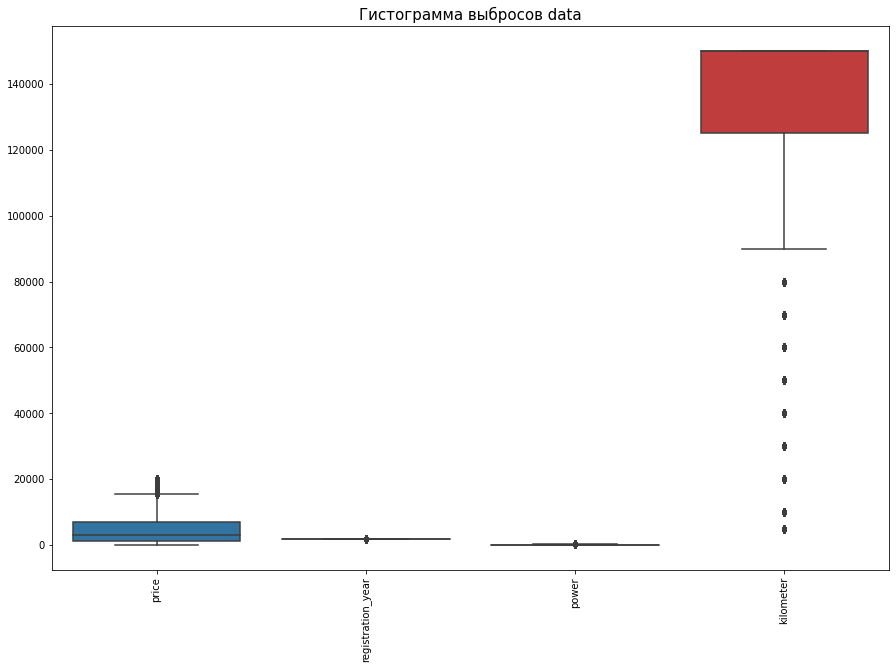

In [42]:
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Гистограмма выбросов data', size=15)
plt.show()

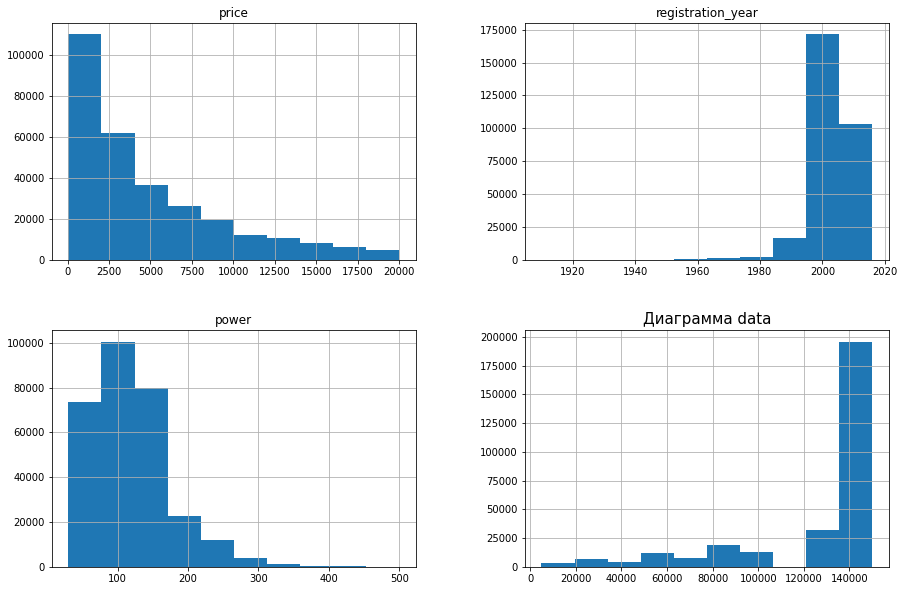

In [43]:
data.hist()
plt.title('Диаграмма data', size=15)
plt.show();

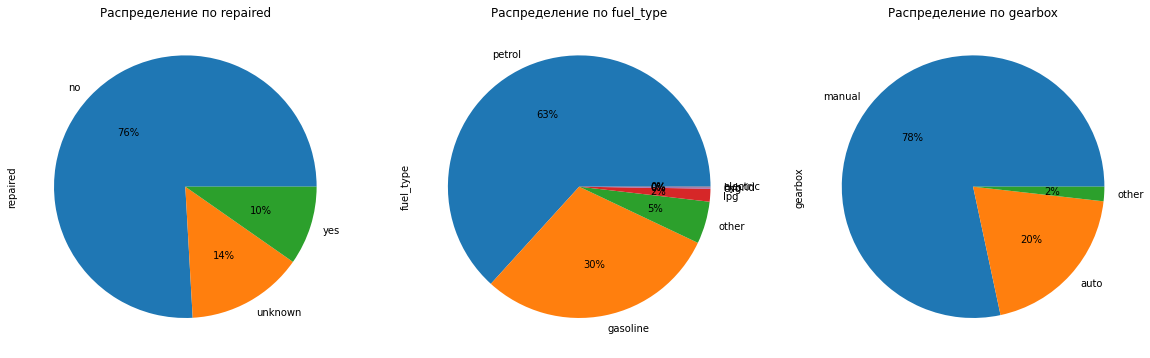

In [44]:
plt.figure(figsize=(20, 20))
#plt.suptitle('Распределение категориальных признаков', fontsize=14, fontweight='bold')

plt.subplot(1, 3, 1)
data['repaired'].value_counts().plot(
    kind='pie', 
    y = data['repaired'].value_counts(),
    autopct = '%1.0f%%',
    title = 'Распределение по repaired')

plt.subplot(1, 3, 2)
data['fuel_type'].value_counts().plot(
    kind='pie', 
    y = data['fuel_type'].value_counts(),
    autopct = '%1.0f%%', 
    title = 'Распределение по fuel_type')

plt.subplot(1, 3, 3)
data['gearbox'].value_counts().plot(
    kind='pie', 
    y = data['gearbox'].value_counts(),
    autopct = '%1.0f%%', 
    title = 'Распределение по gearbox');

После всех наших манипуляций предлагаю снова проверить дубликаты

In [45]:
display(f'Дубликаты data: {data.duplicated().sum()}')

'Дубликаты data: 39183'

После удаления не нужных столбцов образовалось много дубликатов, предлагаю их убрать.

In [46]:
data = data.drop_duplicates()

In [47]:
display(f'Дубликаты data: {data.duplicated().sum()}')

'Дубликаты data: 0'

In [48]:
data.describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99]).T

,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
price,255727.0,4957.545406,4662.965074,50.0,450.0,1399.0,3300.0,7150.0,15216.3,18979.22,20000.0
registration_year,255727.0,2002.920904,6.593401,1910.0,1993.0,1999.0,2003.0,2007.0,2012.0,2016.00,2016.0
power,255727.0,121.701717,53.595456,30.0,55.0,80.0,114.0,150.0,224.0,305.00,500.0
kilometer,255727.0,127409.463999,37238.347691,5000.0,40000.0,125000.0,150000.0,150000.0,150000.0,150000.00,150000.0


In [49]:
data.corr()

,price,registration_year,power,kilometer
price,1.000000,0.474261,0.498853,-0.381371
registration_year,0.474261,1.000000,0.111348,-0.291163
power,0.498853,0.111348,1.000000,0.118248
kilometer,-0.381371,-0.291163,0.118248,1.000000


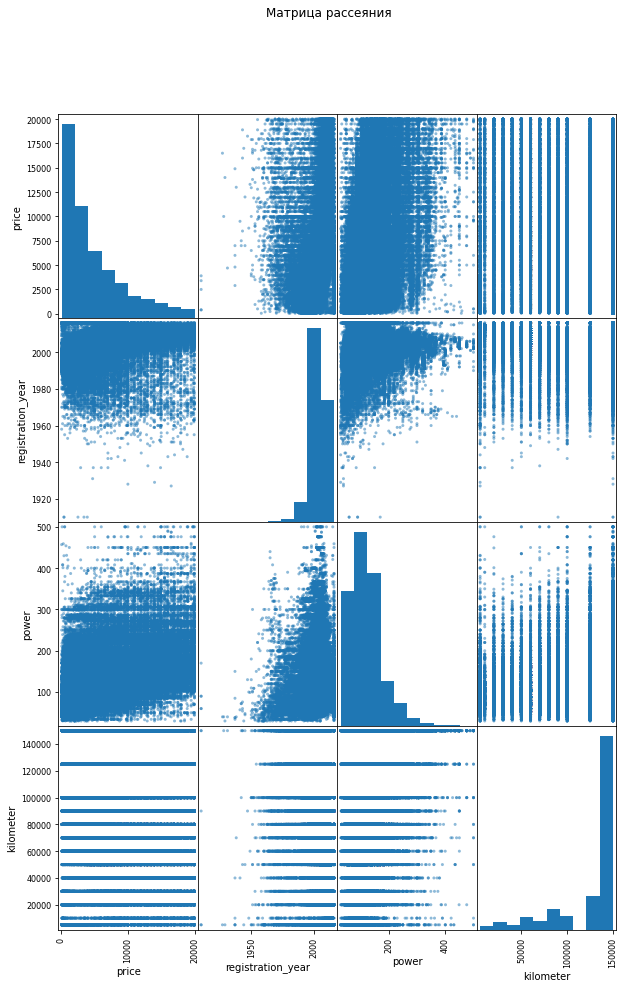

In [50]:
pd.plotting.scatter_matrix(data, figsize=(10, 15), grid=True)
plt.suptitle('Матрица рассеяния')
plt.show();

Выводы: \
После первоначального изучения данных была проделана следующая работа:
* Были обнаружены и удалены лишние входные данные;
* Наименования столбцов приведены к общему виду, согласно PEP8;
* Удалены дубликаты (более 45 тысяч позиций);
* Заполнены пропуски во всех столбцах;
* Удалены аномалии и выбросы;
* Построены гистограммы по все столбцам;
* Проведен корреляционный анализ данных, связь оказалось слабой.

## Обучение моделей

Разобьем на обучающую и тестовую выборки

In [51]:
#data_ohe = pd.get_dummies(data, drop_first=True)
#data_ohe.head()

In [52]:
target_ohe = data['price']
features_ohe = data.drop('price', axis=1)

RANDOM_STATE = 42

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = (
                        train_test_split(features_ohe,
                                         target_ohe,
                                         test_size=0.25,
                                         random_state=RANDOM_STATE)
                                                                            )

Закодируем данные

In [53]:
ohe_encoder = OneHotEncoder(drop='first', sparse=False)

In [54]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [55]:
features_test_ohe.head(3)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
146845,suv,1999,manual,128,grand,150000,other,suzuki,no
98818,small,1999,manual,65,corsa,150000,petrol,opel,no
124643,wagon,2004,auto,150,passat,150000,petrol,volkswagen,no


In [56]:
train_temp = ohe_encoder.fit_transform(features_train_ohe[cat_features]) 
features_train_ohe[ohe_encoder.get_feature_names()] = train_temp 
features_train_ohe.drop(cat_features, axis=1, inplace=True) 

test_temp = ohe_encoder.transform(features_test_ohe[cat_features]) 
features_test_ohe[ohe_encoder.get_feature_names()] = test_temp 
features_test_ohe.drop(cat_features, axis=1, inplace=True) 

/tmp/ipykernel_163/43428153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ohe[ohe_encoder.get_feature_names()] = train_temp
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [57]:
features_train_ohe

,registration_year,power,kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,...,x4_smart,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_unknown,x5_yes
350902,2002,125,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298571,1998,119,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
259756,2008,170,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282889,2012,105,90000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
163979,2007,143,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155005,2001,80,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
132914,2012,265,60000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171657,2008,239,150000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192557,2002,150,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
features_test_ohe

,registration_year,power,kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,...,x4_smart,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_unknown,x5_yes
146845,1999,128,150000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
98818,1999,65,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124643,2004,150,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
173507,2000,122,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
322803,2008,156,125000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117689,2009,143,150000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214350,1997,279,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
336091,2012,107,60000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
53812,1997,204,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [59]:
print(features_train_ohe.shape)
print(target_train_ohe.shape)
print(features_test_ohe.shape)
print(target_test_ohe.shape)

(191795, 307)
(191795,)
(63932, 307)
(63932,)


### Модель линейной регрессии

In [60]:
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)

#predictions_test_ohe = model.predict(features_test_ohe)

#rmse = mean_squared_error(target_test_ohe, predictions_test_ohe)**0.5
#print(f'Корень из квадратичной средней ошибки (RMSE) для модели лин. рег. составляет {round(rmse, 2)}')

LinearRegression()

#Модель линейной регрессии показывает не очень хорошие результаты.

In [61]:
param_grid = {
    'n_jobs': [1, -1]
}

In [62]:
grid_cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

In [63]:
grid_cv.fit(features_train_ohe, target_train_ohe)

GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={'n_jobs': [1, -1]},
             scoring='neg_root_mean_squared_error')

In [64]:
best_score = grid_cv.best_score_*-1

In [65]:
print(f'Корень из квадратичной средней ошибки (RMSE) для модели лин. рег. составляет {round(best_score, 2)}')

Корень из квадратичной средней ошибки (RMSE) для модели лин. рег. составляет 2626.86


### Модель LightGBM

In [66]:
target = data['price']
features = data.drop('price', axis=1)

Для модели LightGBM необходимо перевести признаки в тип Category

In [67]:
for c in features.columns:
  col_type = features[c].dtype
  if col_type == 'object':
    features[c] = features[c].astype('category')

Разобьем на обучающую и тестовую выборки

In [68]:
features_train, features_test, target_train, target_test = (
                            train_test_split(features,
                                             target,
                                             test_size=0.25,
                                             random_state=RANDOM_STATE) 
                                                            )

In [69]:
print(features_train.shape)
print(features_test.shape)

(191795, 9)
(63932, 9)


In [70]:
model = lgb.LGBMRegressor(random_state=RANDOM_STATE)

model.fit(features_train, target_train)

#predictions_test = model.predict(features_test)

#rmse = mean_squared_error(target_test, predictions_test)**0.5
#print(f'Корень из квадратичной средней ошибки (RMSE) для модели LightGBM составляет {round(rmse, 2)}')

LGBMRegressor(random_state=42)

Результат намного лучше чем было с моделью линейной регрессии

Проверим лучшие гиперпараметры

In [71]:
param_grid = {'n_estimators': [100, 500, 1000], 'num_leaves': [n for n in range(20, 300, 20)]}

Результат: \
{'n_estimators': 500, 'num_leaves': 100} \
1595.60

Вывод: Лучше всего справилась модель LightGBM с гиперпараметрами {'n_estimators': 500, 'num_leaves': 100}, метрика RMSE 1595, против 2628 с моделью линейной регрессии

## Анализ моделей

### Время обучения модели линейной регрессии

In [72]:
%%time

model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)

CPU times: user 12.9 s, sys: 4.22 s, total: 17.1 s
Wall time: 17.2 s


LinearRegression()

In [73]:
%%time

predictions_train_ohe = model.predict(features_train_ohe)

CPU times: user 247 ms, sys: 128 ms, total: 375 ms
Wall time: 311 ms


### Время обучения модели LightGBM

In [74]:
%%time

model = lgb.LGBMRegressor(random_state=RANDOM_STATE,
                          n_estimators=500,
                          num_leaves=100)
model.fit(features_train, target_train);

CPU times: user 51.9 s, sys: 0 ns, total: 51.9 s
Wall time: 52.3 s


LGBMRegressor(n_estimators=500, num_leaves=100, random_state=42)

In [75]:
%%time

predictions_train = model.predict(features_train)

CPU times: user 12.7 s, sys: 0 ns, total: 12.7 s
Wall time: 12.8 s


In [76]:
pred = model.predict(features_test)
rmse = mean_squared_error(target_test, pred)**0.5
print(f'Корень из квадратичной средней ошибки (RMSE) для модели LightGBM составляет {round(rmse, 2)}')

Корень из квадратичной средней ошибки (RMSE) для модели LightGBM составляет 1545.61


Вывод: Модель LightGBM учиться в два раза дольше, чем модель линейной регрессии, но зато показывается метрику RMSE намного лучше: 1564 против 2628 на тестовой выборке. 

Рекомендации к заказчику использоваться модель LightGBM, она хоть и дольше, но зато более точная.